In [1]:
%matplotlib inline

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import shutil
import imageio
import matplotlib.pyplot as plt
import re
from PIL import Image

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

## 1. Load and split image data

#### MADOS

In [3]:
# Set parameters
image_folder = 'data/cameraRGB'  # Path to your image folder
mask_folder = 'data/cameraMask_png'  # Path to your mask folder
img_height = 96  # Target image height
img_width = 128  # Target image width

In [57]:
# 1. Load Images and Masks
def load_images_and_masks(image_folder, mask_folder, img_height, img_width):
    """
    Load images and corresponding masks from given directories, resize to target dimensions.
    
    :param image_folder: Path to the folder containing images (e.g., cameraRGB)
    :param mask_folder: Path to the folder containing masks (e.g., cameraMask)
    :param img_height: Desired height of the image
    :param img_width: Desired width of the image
    
    :return: Tuple (images, masks) where images and masks are NumPy arrays.
    """
    image_paths = sorted([os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith('.png')])
    mask_paths = sorted([os.path.join(mask_folder, fname) for fname in os.listdir(mask_folder) if fname.endswith('.png')])

    images = np.empty((len(image_paths), img_height, img_width, 3), dtype=np.float32)
    masks = np.empty((len(mask_paths), img_height, img_width, 1), dtype=np.float32)

    for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        image = load_img(image_path, target_size=(img_height, img_width))
        mask = load_img(mask_path, target_size=(img_height, img_width), color_mode="grayscale")
        images[i] = img_to_array(image)#  / 255.0  # Normalize images to [0, 1]
        masks[i] = img_to_array(mask)#  / 255.0  # Normalize masks to [0, 1]

    return images, masks


# 2. Data Augmentation
def data_augmentation(image, mask, img_height, img_width):
    """
    Apply random augmentations such as zoom, flips, brightness, and contrast to both images and masks.
    
    :param image: Input image (NumPy array)
    :param mask: Input mask (NumPy array)
    :param img_height: Desired height of the image
    :param img_width: Desired width of the image
    
    :return: Augmented image and mask
    """
    # Apply random zoom
    #zoom_factor = np.random.uniform(0.8, 1.2)  # Random zoom between 80% and 120%
    zoom_factor = 1.5 # just zoom up for debris
    image = tf.image.resize(image, (int(img_height * zoom_factor), int(img_width * zoom_factor)))
    mask = tf.image.resize(mask, (int(img_height * zoom_factor), int(img_width * zoom_factor)))

    # Crop to the original size after zooming
    image = tf.image.resize_with_crop_or_pad(image, img_height, img_width)
    mask = tf.image.resize_with_crop_or_pad(mask, img_height, img_width)

    # Random horizontal flip
    if np.random.rand() > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Random vertical flip
    if np.random.rand() > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.2)

    # Random contrast
    image = tf.image.random_contrast(image, lower=0.3, upper=1.0)

    return image, mask


# 3. Split Dataset
def split_dataset(images, masks, train_size=0.8, val_size=0.1, test_size=0.1):
    """
    Split dataset into training, validation, and test sets.

    :param images: Array of images (NumPy array)
    :param masks: Array of masks (NumPy array)
    :param train_size: Fraction of data to be used for training
    :param val_size: Fraction of data to be used for validation
    :param test_size: Fraction of data to be used for testing
    
    :return: Tuple of train, validation, test datasets (images, masks)
    """
    # First, split into train+val and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(images, masks, test_size=test_size, random_state=42)
    # Then, split train+val into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size/(train_size + val_size), random_state=42)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


def augment_data(X, y, img_height, img_width, augmentation_factor=1):
    """
    Augments the dataset by generating new images through augmentations.
    
    :param X: Input images
    :param y: Input masks
    :param img_height: Height of the image
    :param img_width: Width of the image
    :param augmentation_factor: How many augmented versions to create for each original image
    :return: Augmented dataset (images and masks)
    """
    augmented_images = []
    augmented_masks = []

    for i in range(len(X)):
        for _ in range(augmentation_factor):  # Generate 'augmentation_factor' augmented images per original
            image, mask = data_augmentation(X[i], y[i], img_height, img_width)
            augmented_images.append(image)
            augmented_masks.append(mask)
    
    return np.array(augmented_images), np.array(augmented_masks)

In [58]:
# 1. Load images and masks
images, masks = load_images_and_masks(image_folder, mask_folder, img_height, img_width)

# 2. Split the dataset into training, validation, and test sets
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_dataset(images, masks)

# 3. Apply augmentation to the training data
X_train_aug, y_train_aug = augment_data(X_train, y_train, img_height, img_width)

# 4. Combine original and augmented images
X_train_combined = np.concatenate((X_train, X_train_aug), axis=0)
y_train_combined = np.concatenate((y_train, y_train_aug), axis=0)

In [51]:
# 5. Print the shapes to verify the data
print(f'Combined Train images shape: {X_train_combined.shape}')
print(f'Combined Train masks shape: {y_train_combined.shape}')

# 4. Print the shapes to verify the data
print(f'Train images shape: {X_train.shape}')
print(f'Train masks shape: {y_train.shape}')
print(f'Validation images shape: {X_val.shape}')
print(f'Validation masks shape: {y_val.shape}')
print(f'Test images shape: {X_test.shape}')
print(f'Test masks shape: {y_test.shape}')

# Example: Training the U-Net model (replace with your U-Net model)
# unet_model.fit(X_train_aug, y_train_aug, validation_data=(X_val, y_val), batch_size=batch_size, epochs=10)


Combined Train images shape: (4482, 96, 128, 3)
Combined Train masks shape: (4482, 96, 128, 1)
Train images shape: (2241, 96, 128, 3)
Train masks shape: (2241, 96, 128, 1)
Validation images shape: (281, 96, 128, 3)
Validation masks shape: (281, 96, 128, 1)
Test images shape: (281, 96, 128, 3)
Test masks shape: (281, 96, 128, 1)


In [52]:
def get_label(mask):
    """
    Get the class label and class name of the second-highest predicted class.
    
    :param mask: The predicted or ground truth mask (2D array)
    :return: The class label and class name of the second-highest class
    """
    print(mask.shape)
    #print(mask)
    mask = mask.astype(np.int32)
    flattened_mask = mask.flatten()
    # Calculate the class counts
    class_counts = np.bincount(flattened_mask)
    print("Class counts:", class_counts)

    # If there is only one unique class, return that class as both the highest and second-highest class
    if len(class_counts) == 1:
        second_highest_class_label = class_counts.argmax()  # Only one class, return it
        second_highest_class_name = class_names[second_highest_class_label]
    else:
        # Sort the classes in descending order based on the counts (ignoring class 0 if it's background)
        sorted_indices = np.argsort(class_counts)[::-1]  # Sort in descending order
        
        # Avoid selecting the background class (usually class 0) as the second-highest class
        if sorted_indices[0] == 0:
            second_highest_class_label = sorted_indices[1]  # Skip class 0, which is typically the background
        else:
            second_highest_class_label = sorted_indices[0]  # If background is not first, pick the highest

        second_highest_class_name = class_names[second_highest_class_label]

    return second_highest_class_label, second_highest_class_name


In [72]:
def plot_images(images, masks, mark, num_samples=3):
    """
    Plots the augmented images along with their corresponding masks.
    
    :param images: List or array of images
    :param masks: List or array of masks corresponding to the images
    :param num_samples: Number of samples to display
    """
    # Create a figure with subplots to display images and their masks
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples*5))

    for i in range(num_samples):
        # Select a random augmented image and mask
        image = images[i]
        mask = masks[i]

        # Plot the augmented image
        if image.dtype != np.uint8:
            # If the image is float32, it should already be in the range [0.0, 255.0]
            image = np.clip(image, 0, 255).astype(np.uint8)  # Ensure values are in the [0, 255] range
        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"{mark} Image {i+1}")

        # Plot the corresponding mask
        axes[i, 1].imshow(mask.squeeze(), cmap='gray')  # Mask is grayscale, so use 'gray' colormap
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Mask {i+1}")

    plt.tight_layout()
    plt.show()


In [68]:
def plot_image_mask(images, masks, mark, num_samples=3):
    """
    Plots the augmented images along with their corresponding masks and second-highest class labels.
    
    :param images: List or array of images
    :param masks: List or array of masks corresponding to the images
    :param mark: A string (e.g., 'Augmented', 'Original') to label the images
    :param num_samples: Number of samples to display
    """

    # Create a figure with subplots to display images and their masks
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples*5))

    for i in range(num_samples):
        # Select a random augmented image and mask
        image = images[i]
        mask = masks[i]
        
        #print(f'{image.shape=},{type(image)},{image.dtype}')
        ##print(image)
        #print(f'{mask.shape=}')

        # Get the second-highest class label and name from the mask
        second_highest_class_label, second_highest_class_name = get_label(mask)
        print(f'{i},{second_highest_class_label=}, {second_highest_class_name=}')
            
        # Plot the augmented image
        if image.dtype != np.uint8:
            # If the image is float32, it should already be in the range [0.0, 255.0]
            image = np.clip(image, 0, 255).astype(np.uint8)  # Ensure values are in the [0, 255] range

        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"{mark} Image {i+1}")

        # Plot the corresponding mask
        axes[i, 1].imshow(mask.squeeze(), cmap='gray')  # Mask is grayscale, so use 'gray' colormap
        axes[i, 1].axis('off')

        # Display the second-highest class label and name on the mask image
        axes[i, 1].set_title(f"Mask {i+1}\nClass: {second_highest_class_name} ({second_highest_class_label})")

    plt.tight_layout()
    plt.show()


In [24]:
class_names = ['Non-annotated',
        'Marine Debris',
        'Dense Sargassum',
        'Sparse Floating Algae',
        'Natural Organic Material',
        'Ship',
        'Oil Spill',
        'Marine Water',
        'Sediment-Laden Water',
        'Foam',
        'Turbid Water',
        'Shallow Water',
        'Waves and Wakes',
        'Oil Platform',
        'Jellyfish',
        'Sea snot']

(96, 128, 1)
Class counts: [12286     2]
0,second_highest_class_label=1, second_highest_class_name='Marine Debris'
(96, 128, 1)
Class counts: [12075     0     0     0     0     0     0   213]
1,second_highest_class_label=7, second_highest_class_name='Marine Water'


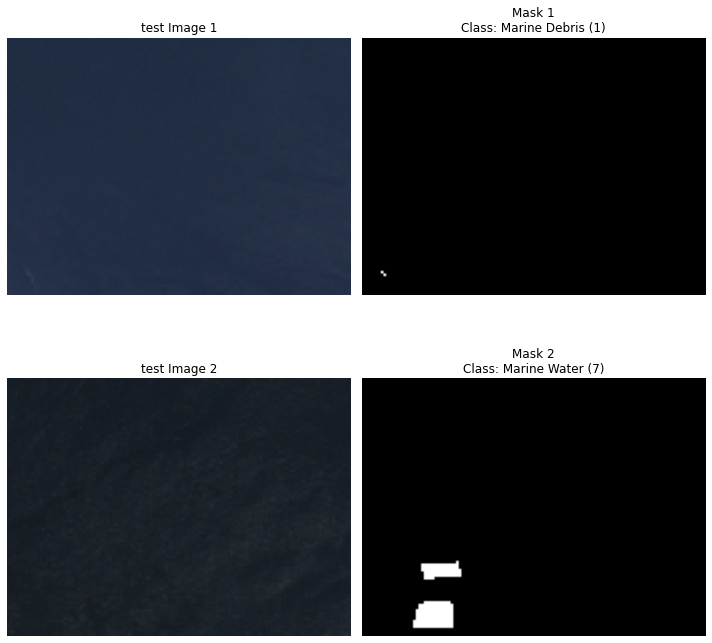

In [69]:
# Show images and masks
plot_image_mask(X_test, y_test, 'test', num_samples=2)

(96, 128, 1)
Class counts: [12256     0     0     0     0     0     0     6     0     0    26]
0,second_highest_class_label=10, second_highest_class_name='Turbid Water'
(96, 128, 1)
Class counts: [11148     0     0     0     0     0     0     0     0     0  1140]
1,second_highest_class_label=10, second_highest_class_name='Turbid Water'
(96, 128, 1)
Class counts: [12269     0     0     0     0     0     0     0     0     0     0     0
     0    19]
2,second_highest_class_label=13, second_highest_class_name='Oil Platform'


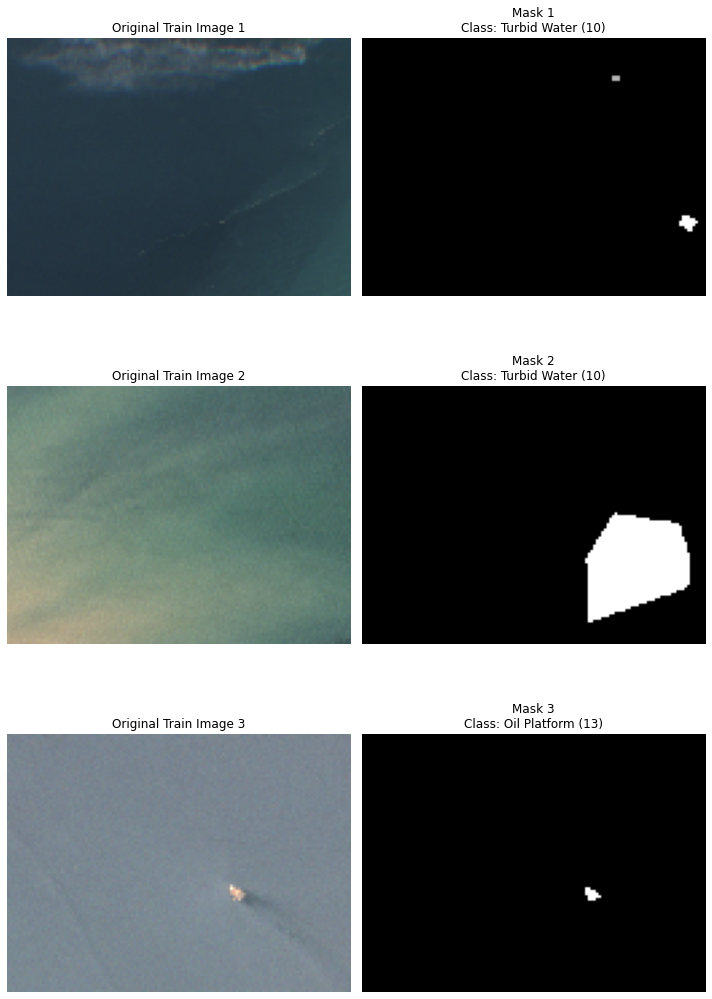

In [70]:
plot_image_mask(X_train, y_train, 'Original Train', num_samples=3)

(96, 128, 1)
Class counts: [12286     2]
0,second_highest_class_label=1, second_highest_class_name='Marine Debris'
(96, 128, 1)
Class counts: [12075     0     0     0     0     0     0   213]
1,second_highest_class_label=7, second_highest_class_name='Marine Water'
(96, 128, 1)
Class counts: [12260     0     0     0     0     0     0     0     0     0     0    28]
2,second_highest_class_label=11, second_highest_class_name='Shallow Water'


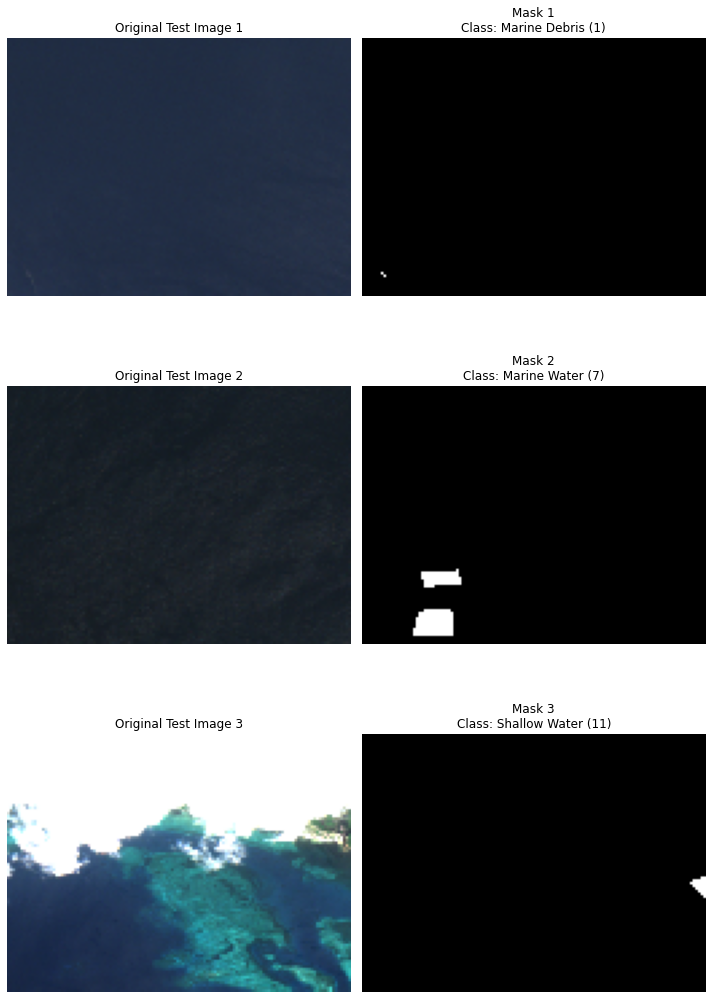

In [74]:
plot_image_mask(X_test, y_test, 'Original Test', num_samples=3)

## 2. Model (U-Net)

### 2.1 Encoder
* 2 Conv, MaxPooling, and dropout

In [75]:
# conv_block
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  # set 'kernel_initializer' same as above
                  kernel_initializer='he_normal')(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D((2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

### 2.2 Decoder

In [76]:
#upsampling_block
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                  # set 'kernel_initializer' same as above
                 kernel_initializer='he_normal')(conv)
    
    return conv

### 2.3 U-Net

In [77]:
len(class_names)

16

In [78]:
# unet_model
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=16):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    cblock1 = conv_block(inputs, n_filters)
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    # Expanding Path (decoding)
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters*8)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [82]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_22 (Conv2D)             (None, 96, 128, 32)  896         ['input_2[0][0]']                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_22[0][0]']              
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 48, 64, 32)  0           ['conv2d_23[0][0]']        

Total params: 8,640,240
Trainable params: 8,640,240
Non-trainable params: 0
__________________________________________________________________________________________________


### UNet++

In [79]:
# Convolutional Block
def conv_block_pp(inputs, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = MaxPooling2D((2, 2))(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

# Upsampling Block
def upsampling_block_pp(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    up = Conv2DTranspose(n_filters, 3, strides=2, padding='same')(expansive_input)
    
    contractive_input_resized = tf.image.resize(contractive_input, (tf.shape(up)[1], tf.shape(up)[2]))
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input_resized], axis=3)
    
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    
    return conv

# U-Net++ Model
def unet_plusplus(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    inputs = Input(input_size)

    # Encoder Path (Contracting)
    c1, s1 = conv_block_pp(inputs, n_filters)
    c2, s2 = conv_block_pp(c1, n_filters*2)
    c3, s3 = conv_block_pp(c2, n_filters*4)
    c4, s4 = conv_block_pp(c3, n_filters*8)

    # Decoder Path (Expanding) with Skip Connections
    u4 = upsampling_block_pp(c4, s3, n_filters*4)
    u3 = upsampling_block_pp(u4, s2, n_filters*2)
    u2 = upsampling_block_pp(u3, s1, n_filters)

    # Nested skip pathways
    u3_ = upsampling_block_pp(u4, s2, n_filters*2)
    u2_ = upsampling_block_pp(u3_, s1, n_filters)
    u1_ = upsampling_block_pp(u2_, inputs, n_filters)

    # Final Conv to refine the output
    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u1_)

    # Output layer
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

# Instantiate and print model summary
unet_pp = unet_plusplus(input_size=(96, 128, 3), n_filters=32, n_classes=16)
unet_pp.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 128, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 64, 32)   0           ['conv2d_1[0][0]']           

 conv2d_15 (Conv2D)             (None, 24, 32, 64)   36928       ['conv2d_14[0][0]']              
                                                                                                  
 conv2d_transpose_4 (Conv2DTran  (None, 48, 64, 32)  18464       ['conv2d_15[0][0]']              
 spose)                                                                                           
                                                                                                  
 tf.compat.v1.shape_8 (TFOpLamb  (4,)                0           ['conv2d_transpose_4[0][0]']     
 da)                                                                                              
                                                                                                  
 tf.compat.v1.shape_9 (TFOpLamb  (4,)                0           ['conv2d_transpose_4[0][0]']     
 da)                                                                                              
          

### 2.4 Loss function

In [85]:
#!pip install tensorflow-addons

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.8.3 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Obtaining dependency information for tensorflow-addons from https://files.pythonhosted.org/packages/ef/97/987e3c3e590464b9435f2eecc13347ff789bd83753421becc522655d7f98/tensorflow_addons-0.21.0-cp38-cp38-win_amd64.whl.metadata
  Obtaining dependency information for typeguard<3.0.0,>=2.7 from https://files.pythonhosted.org/packages/9a/bb/d43e5c75054e53efce310e79d63df0ac3f25e34c926be5dffb7d283fb2a8/typeguard-2.13.3-py3-none-any.whl.metadata
   ---------------------------------------- 729.9/729.9 kB 1.9 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0


### 2.5 Train the UNet with focal loss

In [80]:
initial_learning_rate = 0.001

# Create an exponential decay function
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=1000,  # Number of steps after which to apply decay
    decay_rate=0.96,   # Decay rate
    staircase=True      # Apply decay after each decay step
)

In [83]:
import tensorflow_addons as tfa

unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                   loss=tfa.losses.SigmoidFocalCrossEntropy(alpha=0.25, gamma=2.0),
                   metrics=['accuracy'])


In [88]:
EPOCHS = 1
BATCH_SIZE = 32

unet_history = unet.fit(X_train_combined, y_train_combined, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS)

123/123 [==============================] - 308s 2s/step - loss: 13.1958 - accuracy: 0.0000e+00 - val_loss: 0.0322 - val_accuracy: 0.0000e+00


In [89]:
# Evaluate the model on the test data
test_loss, test_accuracy = unet.evaluate(X_test)

print(f"UNet with focal loss Test Loss: {test_loss}")
print(f"UNet with focal loss Test Accuracy: {test_accuracy}")

14/14 [==============================] - 0s 846us/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
UNet with focal loss Test Loss: 0.0
UNet with focal loss Test Accuracy: 0.0


### 2.6 Train the UNet++ with focal loss

In [25]:
unet_pp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                   loss=tfa.losses.SigmoidFocalCrossEntropy(alpha=0.25, gamma=2.0),
                   metrics=['accuracy'])

In [91]:
EPOCHS=1
unet_pp_history = unet_pp.fit(X_train_combined, y_train_combined, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS)

123/123 [==============================] - 209s 2s/step - loss: nan - accuracy: 0.9903 - val_loss: nan - val_accuracy: 0.9885


In [92]:
# Evaluate the model on the test data
test_loss_pp, test_accuracy_pp = unet_pp.evaluate(X_test)

print(f"UNet++ with focal loss Test Loss: {test_loss_pp}")
print(f"UNet++ with focal loss Test Accuracy: {test_accuracy_pp}")

14/14 [==============================] - 0s 846us/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
UNet++ with focal loss Test Loss: 0.0
UNet++ with focal loss Test Accuracy: 0.0


### 2.6 Plot Model Accuracy

In [26]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.
    
    :param history: History object from the model's fit() method
    """
    # Extract accuracy and loss from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Create subplots for accuracy and loss
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plot training & validation accuracy
    axs[0].plot(acc, label='Training Accuracy')
    axs[0].plot(val_acc, label='Validation Accuracy')
    axs[0].set_title('Training and Validation Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    # Plot training & validation loss
    axs[1].plot(loss, label='Training Loss')
    axs[1].plot(val_loss, label='Validation Loss')
    axs[1].set_title('Training and Validation Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

#### 2.6.2 UNet with focal loss

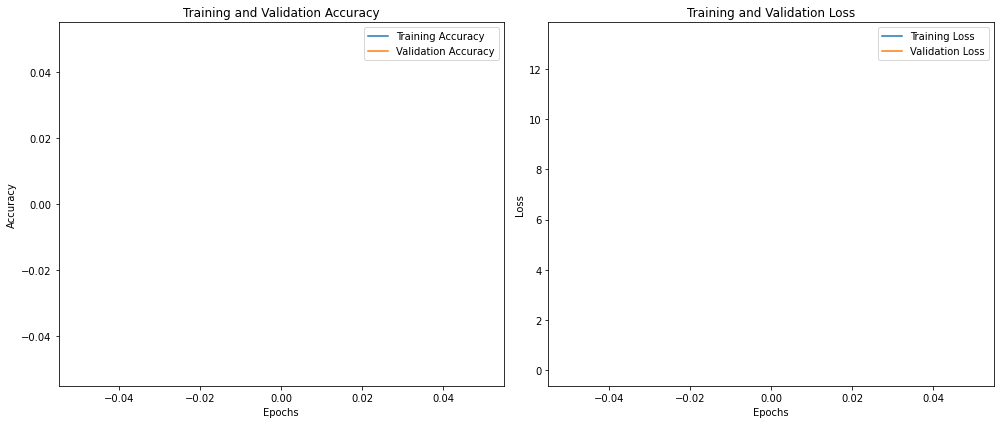

In [94]:
# plot the training history
plot_training_history(unet_history)

#### 2.6.2 UNet++ with focal loss

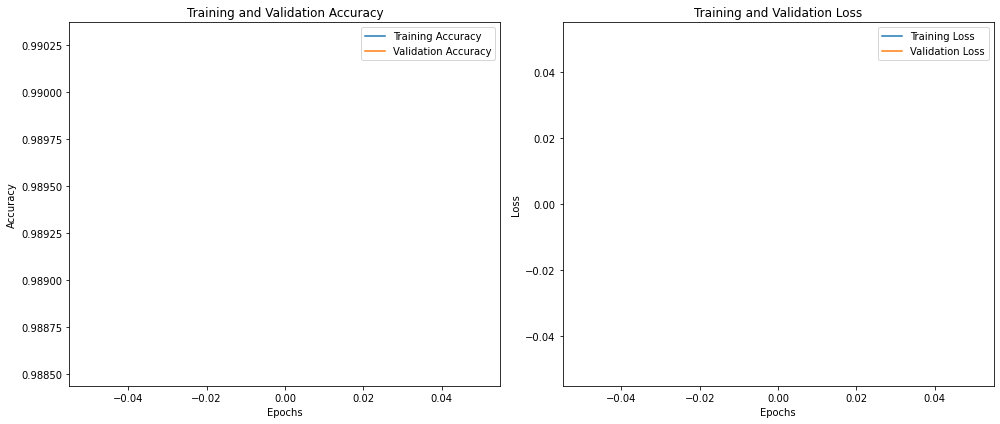

In [95]:
# plot the training history
plot_training_history(unet_pp_history)

### 2.7 Save and load model

In [96]:
# Save UNet
unet.save('save/unet_model_v1')

INFO:tensorflow:Assets written to: save/unet_model_v1\assets


INFO:tensorflow:Assets written to: save/unet_model_v1\assets


In [27]:
#load UNet 
unet = tf.keras.models.load_model('save/unet_model_v1')
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 128, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 64, 32)   0           ['conv2d_1[0][0]']           

Total params: 8,640,240
Trainable params: 8,640,240
Non-trainable params: 0
__________________________________________________________________________________________________


In [98]:
# Save UNet++
unet_pp.save('save/unetpp_model_v1')

INFO:tensorflow:Assets written to: save/unetpp_model_v1\assets


INFO:tensorflow:Assets written to: save/unetpp_model_v1\assets


In [28]:
#load UNet++
unet_pp = tf.keras.models.load_model('save/unetpp_model_v1')
unet_pp.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 96, 128, 32)  896         ['input_2[0][0]']                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_20[0][0]']              
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 48, 64, 32)  0           ['conv2d_21[0][0]']        

 conv2d_35 (Conv2D)             (None, 24, 32, 64)   36928       ['conv2d_34[0][0]']              
                                                                                                  
 conv2d_transpose_8 (Conv2DTran  (None, 48, 64, 32)  18464       ['conv2d_35[0][0]']              
 spose)                                                                                           
                                                                                                  
 tf.compat.v1.shape_8 (TFOpLamb  (4,)                0           ['conv2d_transpose_8[0][0]']     
 da)                                                                                              
                                                                                                  
 tf.compat.v1.shape_9 (TFOpLamb  (4,)                0           ['conv2d_transpose_8[0][0]']     
 da)                                                                                              
          

### 2.6 Test

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2 

def preprocess_image(image_path, img_height, img_width):
    """
    Preprocess the image for model prediction: load and resize it to the input size of the model.
    
    :param image_path: Path to the image file
    :param img_height: Height to resize the image
    :param img_width: Width to resize the image
    :return: Preprocessed image
    """
    image = load_img(image_path, target_size=(img_height, img_width))
    image = img_to_array(image) / 255.0  # Normalize image to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def preprocess_mask(mask_path, img_height, img_width):
    """
    Load and preprocess the ground truth mask (resize and normalize).
    
    :param mask_path: Path to the ground truth mask
    :param img_height: Height to resize the mask
    :param img_width: Width to resize the mask
    :return: Preprocessed mask
    """
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load the mask as grayscale
    mask = cv2.resize(mask, (img_width, img_height))  # Resize mask to match input image size
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
    mask = np.expand_dims(mask, axis=0)  # Add batch dimension
    return mask 



def predict_and_display(image_path, model, img_height, img_width, ground_truth_mask_path=None):
    """
    Predict the mask for a single image and display the result.
    
    :param image_path: Path to the input image
    :param model: The trained model
    :param img_height: Image height
    :param img_width: Image width
    :param ground_truth_mask_path: (Optional) Path to the ground truth mask for comparison
    """
    # Preprocess the input image
    image = preprocess_image(image_path, img_height, img_width)

    # Predict the mask
    predicted_mask = model.predict(image)

    # If the model predicts multi-class segmentation (multiple channels), use argmax to pick the class
    if predicted_mask.shape[-1] > 1:  # Multi-class case
        predicted_mask = np.argmax(predicted_mask, axis=-1)  # Get the class with highest probability
        predicted_mask = np.expand_dims(predicted_mask, axis=-1)  # Add channel dimension

    # Convert the predicted mask to binary (if necessary)
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Threshold for binary mask

    # Get the predicted class label and name for the second-highest class
    second_highest_predicted_class_label, second_highest_predicted_class_name = get_label(predicted_mask)
    predict_str = f"Predicted: {second_highest_predicted_class_label}:{second_highest_predicted_class_name}"

    # Plot the original image, predicted mask, and ground truth mask
    plt.figure(figsize=(15, 15))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(image[0])  # Remove batch dimension for display
    plt.title('Original Image')
    plt.axis('off')

    # Predicted mask
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask[0].squeeze(), cmap='tab20b')  # Use a colormap for multi-class
    plt.title(predict_str)
    plt.axis('off')

    # If ground truth mask is provided, display it
    if ground_truth_mask_path is not None:
        ground_truth_mask = preprocess_mask(ground_truth_mask_path, img_height, img_width)
        
        # Ensure the ground truth mask is an integer type
        ground_truth_mask = ground_truth_mask.astype(np.uint8)
        
        # Get the ground truth class label and name for the second-highest class (if ground truth is provided)
        second_highest_ground_truth_class_label, second_highest_ground_truth_class_name = get_label(ground_truth_mask)
        gt_str = f"GT: {second_highest_ground_truth_class_label}:{second_highest_ground_truth_class_name}"

        plt.subplot(1, 3, 3)
        plt.imshow(ground_truth_mask.squeeze(), cmap='tab20b')  # Use the same colormap for comparison
        plt.title(gt_str)
        plt.axis('off')

    plt.show()

### UNet Test

1/1 [==============================] - 0s 453ms/step
Class counts: [    0 12288]
Class counts: [12114    12    15    10     7    44    86]


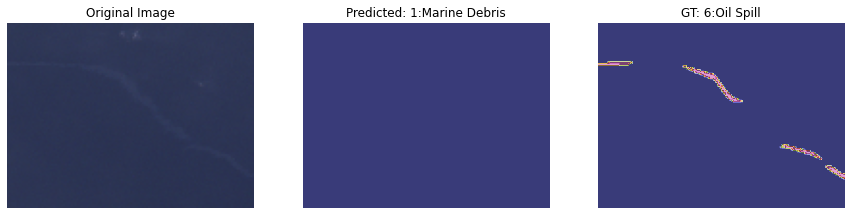

In [32]:
image_path = image_folder+'/Scene_0_L2R_rgb_6.png'  # Replace with the path to your test image
ground_truth_mask_path = mask_folder+'/Scene_0_L2R_cl_6.png'  # Replace with the path to your ground truth mask
model = unet 
predict_and_display(image_path, model, img_height=96, img_width=128, ground_truth_mask_path=ground_truth_mask_path)

1/1 [==============================] - 1s 824ms/step
Class counts: [12288]
Class counts: [12114    12    15    10     7    44    86]


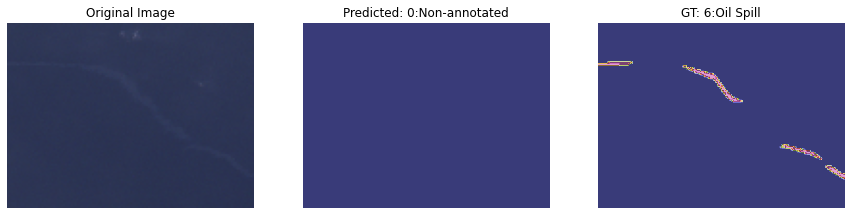

In [31]:
image_path = image_folder+'/Scene_0_L2R_rgb_6.png'  # Replace with the path to your test image
ground_truth_mask_path = mask_folder+'/Scene_0_L2R_cl_6.png'  # Replace with the path to your ground truth mask
model = unet_pp 
predict_and_display(image_path, model, img_height=96, img_width=128, ground_truth_mask_path=ground_truth_mask_path)